In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mixedbridge.stochastic_processes.bases import ContinuousTimeProcess
from mixedbridge.stochastic_processes.wiener import WienerProcess
from mixedbridge.solvers.sde import Euler

**$\mathbb{P}$: OU process**
$$
\mathrm{d}X_t = -\gamma\cdot X_t\mathrm{d}t + \sigma\mathrm{d}W_t
$$
**$\mathbb{P}^*$: OU Bridge**
$$
\mathrm{d}X^*_t = \left\{ -\gamma\cdot X_t + \frac{4\gamma^2e^{-\gamma(T-t)}(X^*_t\cdot e^{-\gamma(T-t)} - X_T)}{e^{-2\gamma(T-t)} - 1}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
**$\mathbb{P}^\circ$: Brownian bridge**
$$
\mathrm{d}X^\circ_t = \frac{X_T-X^\circ_t}{T-t}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
**$\mathbb{P}^\diamond$: Brownian bridge + NN**
$$
\mathrm{d}X^\diamond_t = \left\{\frac{X_T-X^\diamond_t}{T-t} + \sigma\cdot\nu_\theta(t, X^\diamond_t)\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
Set $\sigma=\gamma=1$

In [2]:
sigma = 1.0
gamma = 1.0
T = 1.0
x0 = jnp.array([0.0])
xT = jnp.array([1.0])

def ou_drift(t, x):
    return -gamma * x

def brownian_drift(t, x):
    return jnp.asarray(0.0)

def ou_bridge_drift(t, x):
    return -gamma * x + \
        4.0 * gamma**2 * jnp.exp(-gamma * (T - t)) \
            * (x * jnp.exp(-gamma * (T - t)) - xT) / (jnp.exp(-2.0 * gamma * (T - t)) - 1.0)

def brownian_bridge_drift(t, x):
    return (xT - x) / (T - t)

def brownian_mixed_bridge_drift(t, x, nu):
    return brownian_bridge_drift(t, x) + sigma * nu(t, x)

In [3]:
class OUProcess(ContinuousTimeProcess):
    dim = 1
    dtype = jnp.float32
    T = 1.0
    dt = 1e-2
    
    def __init__(self):
        super().__init__()
    
    def f(self, t, x):
        return ou_drift(t, x)

    def g(self, t, x):
        return jnp.array([sigma])
    
    def Sigma(self, t, x):
        return jnp.array([sigma**2])
    
class OUBridgeProcess(ContinuousTimeProcess):
    dim = 1
    dtype = jnp.float32
    T = 1.0
    dt = 1e-2
    
    def __init__(self):
        super().__init__()
    
    def f(self, t, x):
        return ou_bridge_drift(t, x)

    def g(self, t, x):
        return jnp.array([sigma])
    
    def Sigma(self, t, x):
        return jnp.array([sigma**2])
    
class BrownianBridgeProcess(ContinuousTimeProcess):
    dim = 1
    dtype = jnp.float32
    T = 1.0
    dt = 1e-2
    
    def __init__(self):
        super().__init__()
    
    def f(self, t, x):
        return brownian_bridge_drift(t, x)

    def g(self, t, x):
        return jnp.array([1.0])
    
    def Sigma(self, t, x):
        return jnp.array([1.0])
    
class BrownianMixedBridgeProcess(ContinuousTimeProcess):
    dim = 1
    dtype = jnp.float32
    T = 1.0
    dt = 1e-2
    
    def __init__(self, nu):
        super().__init__()
        self.nu = nu
    
    def f(self, t, x):
        return brownian_mixed_bridge_drift(t, x, self.nu)

    def g(self, t, x):
        return jnp.array([1.0])
    
    def Sigma(self, t, x):
        return jnp.array([1.0])

**Test with closed forms**
The optimal value of $\nu_\theta(t, x)$ should be $\nabla_x\log\frac{p(t, x;T, x_T)}{\tilde{p}(t, x;T, x_T)}$. Find that:
$$
\nabla_x\log p(t, x;T, x_T) = \frac{4\gamma^2e^{-\gamma(T-t)}(x\cdot e^{-\gamma(T-t)} - x_T)}{\sigma^2(e^{-2\gamma(T-t)} - 1)}
$$
and
$$
\nabla_x\log \tilde{p}(t, x;T, x_T) = \frac{x_T - x}{\sigma^2(T-t)}
$$

In [4]:
def score_p(t, x):
    return 4.0 * gamma**2 * jnp.exp(-gamma * (T - t)) * (x * jnp.exp(-gamma * (T - t)) - xT) \
        / (jnp.exp(-2.0 * gamma * (T - t)) - 1.0) * sigma**2

def score_p_tilde(t, x):
    return (xT - x) / ((T - t) * sigma**2)

def optimal_nu(t, x):
    return sigma * (score_p(t, x) - score_p_tilde(t, x))

In [5]:
key = jax.random.PRNGKey(32)
wiener_process = WienerProcess(dim=1, dtype=jnp.float32)
ou_sde = OUProcess()
ou_bridge_sde = OUBridgeProcess()
brownian_bridge_sde = BrownianBridgeProcess()

In [6]:
ou_solver = Euler(ou_sde, wiener_process)
ou_bridge_solver = Euler(ou_bridge_sde, wiener_process)
brownian_bridge_solver = Euler(brownian_bridge_sde, wiener_process)

In [7]:
# dWs = wiener_process.sample_path(ou_sde.ts).xs
n_batches = 100
# ou_path = ou_solver.solve(x0=jnp.array([0.0]), dWs=None, rng_key=key, n_batches=40)
ou_bridge_path = ou_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=n_batches)
brownian_bridge_path = brownian_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=n_batches)

Text(0.5, 1.0, 'Brownian bridge vs. OU bridge')

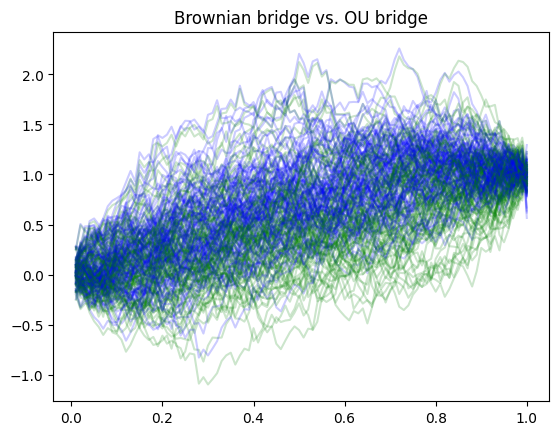

In [8]:
for i in range(n_batches):
    # plt.plot(ou_sde.ts[1:], ou_path.xs[i, :, 0], color="red", alpha=0.1)
    plt.plot(ou_sde.ts[1:], ou_bridge_path.xs[i, :, 0], color="blue", alpha=0.2)
    plt.plot(ou_sde.ts[1:], brownian_bridge_path.xs[i, :, 0], color="green", alpha=0.2)
plt.title("Brownian bridge vs. OU bridge")

**Set up a NN**

In [9]:
from flax import linen as nn
from flax.training import train_state
import optax

In [10]:
# a very simple MLP
class MLP(nn.Module):

    @nn.compact
    def __call__(self, t, x):
        t = jnp.expand_dims(t, axis=-1)
        x = jnp.concatenate([t, x], axis=-1)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(1)(x)
        return x

In [11]:
model = MLP()
dummy_t, dummy_x = jnp.zeros((1, )), jnp.zeros((1, 1))
params = model.init(key, dummy_t, dummy_x)

In [12]:
def nu(t, x):
    return model.apply(params, t, x)

In [13]:
brownian_mixed_bridge = BrownianMixedBridgeProcess(nu=nu)
brownian_mixed_bridge_solver = Euler(brownian_mixed_bridge, wiener_process)
brownian_mixed_bridge_path = brownian_mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=n_batches)

Text(0.5, 1.0, 'Brownian mixed bridge with randomly initialized neural network')

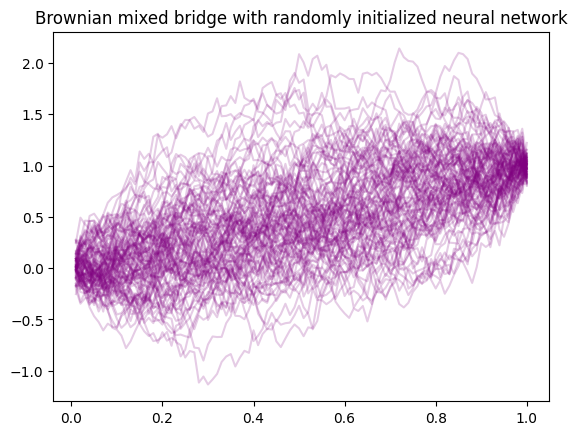

In [14]:
for i in range(n_batches):
    plt.plot(ou_sde.ts[1:], brownian_mixed_bridge_path.xs[i, :, 0], color="purple", alpha=0.2)
plt.title("Brownian mixed bridge with randomly initialized neural network")

In [15]:
def train_model(rng_key, model, path_solver, n_epochs, batch_size):
    rng_key, init_key = jax.random.split(rng_key)
    
    dummy_t, dummy_x = jnp.zeros((1, )), jnp.zeros((1, 1))
    params = model.init(init_key, dummy_t, dummy_x)
    optimizer = optax.adam(1e-2)
    
    model_state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer
    )

    def sample_path(rng_key, path_solver):
        path = path_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=batch_size)
        ts, xs = path.ts, path.xs
        ts = jnp.tile(jnp.expand_dims(ts, axis=0), reps=(batch_size, 1))
        return ts, xs
    
    def compute_loss(state, params, ts, xs):
        nus = state.apply_fn(params, ts, xs)
        norm = jnp.linalg.norm(nus[:, :-1] + (jnp.broadcast_to(xT, xs[:, :-1].shape) - xs[:, :-1]) / jnp.expand_dims((T - ts[:, :-1]), axis=-1) / sigma, axis=-2)
        norm = 0.5 * jnp.sum(norm**2, axis=1) * 0.01
        # bs = jnp.diff(xs, axis=1) - jax.vmap(jax.vmap(ou_drift))(ts[:, :-1], xs[:, :-1]) * 0.01
        bs = jax.vmap(jax.vmap(score_p))(ts, xs)[:, :-1]
        prod = jax.vmap(jax.vmap(jnp.inner))(bs, nus[:, :-1])
        prod = jnp.sum(prod, axis=1) * 0.01
        return (norm - prod).mean(axis=0)
    
    @jax.jit
    def train_step(state, ts, xs):
        grad_fn = jax.value_and_grad(compute_loss, argnums=1, has_aux=False)
        loss, grads = grad_fn(state, state.params, ts, xs)
        state = state.apply_gradients(grads=grads)
        return state, loss
    
    for epoch in range(1, n_epochs + 1):
        rng_key, batch_key = jax.random.split(rng_key)
        ts, xs = sample_path(batch_key, path_solver)
        model_state, loss = train_step(model_state, ts, xs)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, loss: {loss}")
    return model_state

In [16]:
model = MLP()
n_epochs = 3000
batch_size = 64
model_state = train_model(key, model, brownian_bridge_solver, n_epochs, batch_size)

Epoch 100, loss: 0.5656707286834717
Epoch 200, loss: -0.09994781017303467
Epoch 300, loss: -0.30753105878829956
Epoch 400, loss: -0.5548020005226135
Epoch 500, loss: -0.4663536548614502
Epoch 600, loss: -0.3637833595275879
Epoch 700, loss: -0.4142950475215912
Epoch 800, loss: -0.32878535985946655
Epoch 900, loss: -0.4831840693950653
Epoch 1000, loss: -0.2360597401857376
Epoch 1100, loss: -0.3979915976524353
Epoch 1200, loss: -0.28322893381118774
Epoch 1300, loss: -0.3659707009792328
Epoch 1400, loss: -0.5178662538528442
Epoch 1500, loss: -0.5619445443153381
Epoch 1600, loss: -0.6155586242675781
Epoch 1700, loss: -0.4721343517303467
Epoch 1800, loss: -0.3939700126647949
Epoch 1900, loss: -0.23714041709899902
Epoch 2000, loss: -0.5757350921630859
Epoch 2100, loss: -0.20122641324996948
Epoch 2200, loss: -0.4267289638519287
Epoch 2300, loss: -0.3845076858997345
Epoch 2400, loss: -0.3662680387496948
Epoch 2500, loss: -0.4443521499633789
Epoch 2600, loss: -0.557567834854126
Epoch 2700, loss:

In [17]:
def nu(t, x):
    return model_state.apply_fn(model_state.params, t, x)

# def nu(t, x):
#     return jnp.zeros_like(x)

In [18]:
brownian_mixed_bridge = BrownianMixedBridgeProcess(nu=nu)
brownian_mixed_bridge_solver = Euler(brownian_mixed_bridge, wiener_process)
brownian_mixed_bridge_path = brownian_mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=n_batches)

Text(0.5, 1.0, 'Brownian mixed bridge with trained neural network')

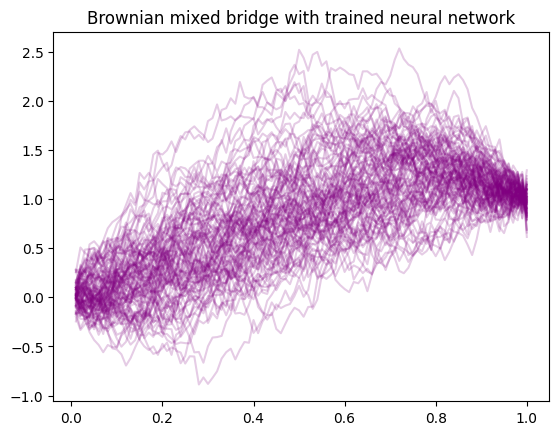

In [19]:
for i in range(n_batches):
    plt.plot(ou_sde.ts[1:], brownian_mixed_bridge_path.xs[i, :, 0], color="purple", alpha=0.2)
plt.title("Brownian mixed bridge with trained neural network")

In [20]:
brownian_mixed_bridge = BrownianMixedBridgeProcess(nu=optimal_nu)
brownian_mixed_bridge_solver = Euler(brownian_mixed_bridge, wiener_process)
brownian_mixed_bridge_path = brownian_mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=n_batches)

Text(0.5, 1.0, 'Brownian mixed bridge with true nu')

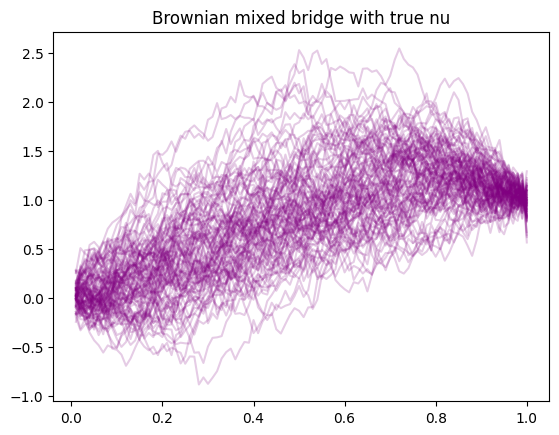

In [21]:
for i in range(n_batches):
    plt.plot(ou_sde.ts[1:], brownian_mixed_bridge_path.xs[i, :, 0], color="purple", alpha=0.2)
plt.title("Brownian mixed bridge with true nu")

In [38]:
ou_bridge_path = ou_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=n_batches)

Text(0.5, 1.0, 'OU bridge with the same rng_key')

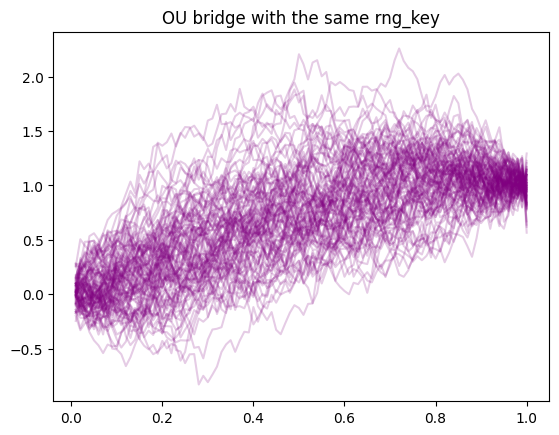

In [39]:
for i in range(n_batches):
    plt.plot(ou_sde.ts[1:], ou_bridge_path.xs[i, :, 0], color="purple", alpha=0.2)
plt.title("OU bridge with the same rng_key")

In [31]:
def train_model(rng_key, model, n_epochs, batch_size):
    rng_key, init_key = jax.random.split(rng_key)
    
    dummy_t, dummy_x = jnp.zeros((1, )), jnp.zeros((1, 1))
    params = model.init(init_key, dummy_t, dummy_x)
    optimizer = optax.adam(1e-5)
    
    model_state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer
    )
    
    def nu(t, x):
        return model_state.apply_fn(model_state.params, t, x)

    def sample_path(rng_key, path_solver):
        path = path_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=batch_size)
        ts, xs = path.ts, path.xs
        ts = jnp.tile(jnp.expand_dims(ts, axis=0), reps=(batch_size, 1))
        return ts, xs
    
    def compute_loss(state, params, ts, xs):
        nus = state.apply_fn(params, ts, xs)
        nus_squared_sum = jnp.sum(nus**2 * 1e-2, axis=1)
        return -0.5 * jnp.mean(nus_squared_sum)
    
    @jax.jit
    def train_step(state, ts, xs):
        grad_fn = jax.value_and_grad(compute_loss, argnums=1, has_aux=False)
        loss, grads = grad_fn(state, state.params, ts, xs)
        state = state.apply_gradients(grads=grads)
        return state, loss
    
    for epoch in range(1, n_epochs + 1):
        rng_key, batch_key = jax.random.split(rng_key)
        process = BrownianMixedBridgeProcess(nu=nu)
        path_solver = Euler(process, wiener_process)
        ts, xs = sample_path(batch_key, path_solver)
        model_state, loss = train_step(model_state, ts, xs)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, loss: {loss}")
    return model_state

In [32]:
model = MLP()
n_epochs = 500
batch_size = 64
model_state = train_model(key, model, n_epochs, batch_size)

Epoch 100, loss: -0.0024534291587769985
Epoch 200, loss: -0.004389416426420212
Epoch 300, loss: -0.004954835865646601
Epoch 400, loss: -0.005821834318339825
Epoch 500, loss: -0.006685418542474508


In [33]:
def nu(t, x):
    return model_state.apply_fn(model_state.params, t, x)

In [34]:
brownian_mixed_bridge = BrownianMixedBridgeProcess(nu=nu)
brownian_mixed_bridge_solver = Euler(brownian_mixed_bridge, wiener_process)
brownian_mixed_bridge_path = brownian_mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=key, n_batches=n_batches)

Text(0.5, 1.0, 'Brownian mixed bridge with trained neural network')

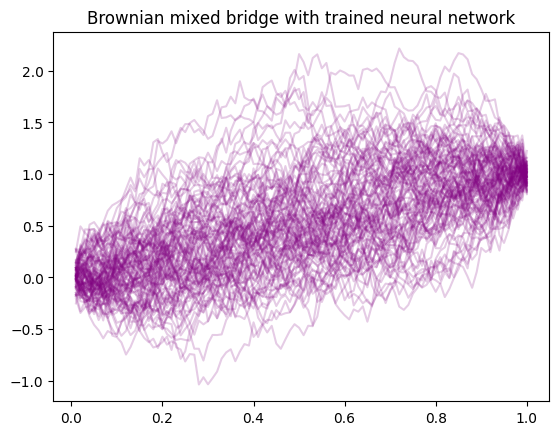

In [35]:
for i in range(n_batches):
    plt.plot(ou_sde.ts[1:], brownian_mixed_bridge_path.xs[i, :, 0], color="purple", alpha=0.2)
plt.title("Brownian mixed bridge with trained neural network")